In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import emcee
import corner
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import WMAP9 as cosmo

La distancia módulo es una forma de parametrizar distancias en el contexto de astronomía y cosmología mediante el uso de escalas logarítmicas. Cuando tratamos con supernovas, tenemos tres parámetros de interés: su color, su forma y su entorno galáctico. Si consideramos que las supernovas con parámetros idénticos presentan en promedio la misma luminosidad intrínsica para todos los corrimientos al rojo, podemos modelar la distancia módulo como

$\mu = m_{B}^{*} - (M_{B} - \alpha \times X_{1} + \beta \times C)$

donde $m_{B}^{*}$ es el pico de la magnitud de la banda $B$, $X_{1}$ es la extensión de la curvatura de luz y $C$ es el color de la supernova en su brillo máximo. Por su parte, $M_{B}$, $\alpha$ y $\beta$ no son otra cosa más que parámetros de ajuste que deben determinarse para que el modelo lineal concuerde con la estandarizaión $\mu = 5 log_{10}(d_{L}/10 pc)$, donde $d_{L}$ representa la distancia luminosa. De acuerdo a la teoría, es posible obtener esta cantidad para un objeto astronómico si conocemos su corrimiento al rojo. Usamos la libreria FlatLambdaCDM con los parámetros del universo actual (constante de Hubble $H_{0} = 70 km s^{-1} Mpc^{-1}$, parámetro de densidad de materia bariónica $\Omega_{0} = 0.3$ y temperatura del universo $T = 2.725 K$) para obtener los valores $d_{L}$ necesarios

In [2]:
datos = np.loadtxt('data/jla_lcparams.txt', usecols = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19))

In [3]:
z = np.zeros(740)

for i in range(740):
    z[i] = datos[i][0]

In [12]:
mb = np.zeros(740)
x1 = np.zeros(740)
c = np.zeros(740)

for i in range(740):
    mb[i] = datos[i][3]
    x1[i] = datos[i][5]
    c[i] = datos[i][7]

In [13]:
err_mb = np.zeros(740)
err_x1 = np.zeros(740)
err_c = np.zeros(740)

for i in range(740):
    err_mb[i] = datos[i][4]
    err_x1[i] = datos[i][6]
    err_c[i] = datos[i][8]

In [14]:
masa_estelar = np.zeros(740)
conjunto = np.zeros(740)

for i in range(740):
    masa_estelar[i] = datos[i][9]
    conjunto[i] = datos[i][16]

Y obtenemos las distancias módulo

In [15]:
err_total = np.zeros(740)
par_masa = np.zeros(740)

for i in range(740):
    err_aux = err_mb[i]**2 + err_x1[i]**2 + err_c[i]**2
    err_total[i] = err_aux

for i in range(740):
    if masa_estelar[i] >= 10:
        par_masa[i] = 1
    else:
        par_masa[i] = 0

In [68]:
def log_likelihood(theta, mb, par_masa, x1, c, z, err_total):
    omega, alfa, beta, masa, delta = theta
    model = mb - (masa + delta*par_masa - alfa*x1 + beta*c)
    omega = abs(omega)
    d_l = FlatLambdaCDM(H0 = 70, Om0 = omega, Tcmb0 = 2.725).luminosity_distance(z)
    mu_stand = np.zeros(740)
    for i in range(740):
        mu_aux = 5*math.log10(d_l[i].value/10e-6)
        mu_stand[i] = mu_aux
    return -0.5 * np.sum((mu_stand - model) ** 2 / err_total + np.log(err_total))

In [69]:
def log_prior(theta):
    omega, alfa, beta, masa, delta = theta
    if 0.0 < omega < 1.0 and 0.0 < alfa < 1.0 and 3 < beta < 4 and -20 < masa < -19 and -1.0 < delta < 0.0:
        prior = 0
    else:
        prior = -np.inf
    return prior

In [70]:
def log_probability(theta, mb, par_masa, x1, c, z, err_total):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, mb, par_masa, x1, c, z, err_total)

In [71]:
pos = [0.3, 0.15, 3.0, -19.0, -0.0070] + 1e-4 * np.random.randn(10, 5)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(mb, par_masa, x1, c, z, err_total))
sampler.run_mcmc(pos, 10000, progress=True);

  0%|          | 0/10000 [00:00<?, ?it/s]/home/chava/miniconda3.8/envs/DA2020II/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [1:23:28<00:00,  2.00it/s]


In [72]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)    #flat=True
print(flat_samples.shape)

(6600, 5)


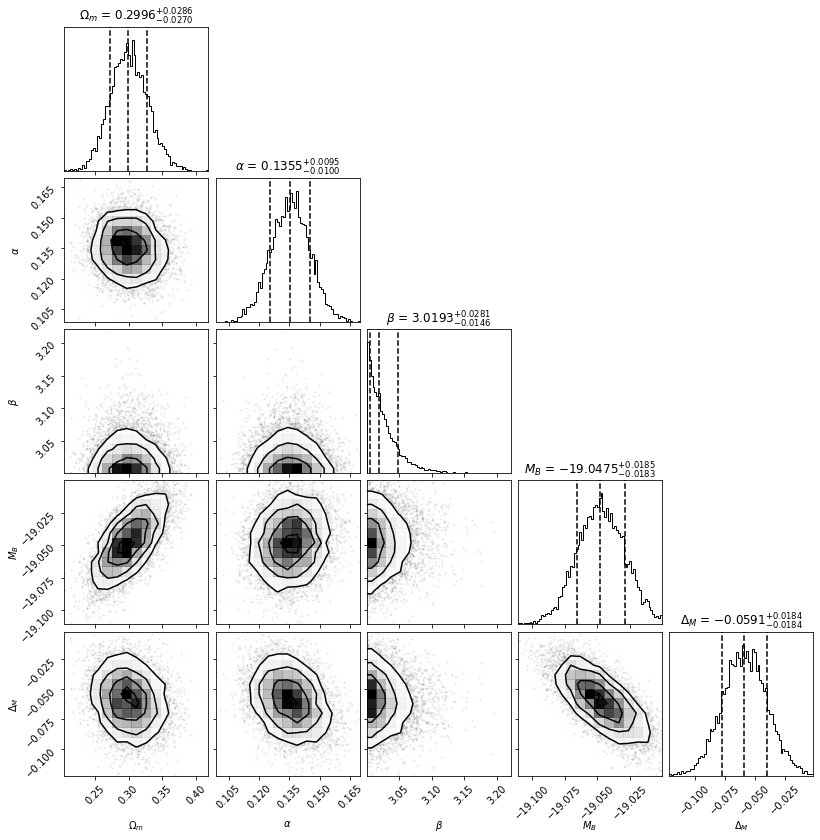

In [73]:
fig = corner.corner(
    flat_samples,
    bins = 15,
    hist_bin_factor = 5,
    labels=[r"$\Omega_m$", r"$\alpha$", r"$\beta$", r"$M_{B}$", r"$\Delta_M$"],
    quantiles = [0.16, 0.5, 0.84],
    title_fmt = '.4f',
    show_titles = True, title_kwargs={"fontsize": 12}
);

In [74]:
from IPython.display import display, Math
labels = [r"\Omega_m", r"\alpha",r"\beta",r"M_{B}",r"\Delta_M"]
res = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    res[i] = mcmc[1]
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [75]:
datos_aux = {'z':z, 'mu_stand':mu_stand}
datos_tabla = pd.DataFrame(datos_aux) 
datos_tabla

,z,mu_stand
0,0.503084,42.277107
1,0.580724,42.652903
2,0.494795,42.233833
3,0.345928,41.314263
4,0.677662,43.060678
...,...,...
735,0.027064,35.365217
736,0.025468,35.230647
737,0.023810,35.081780
738,0.023867,35.087064


In [76]:
datos_ord = datos_tabla.sort_values(by = 'z', ignore_index = True)
datos_ord

,z,mu_stand
0,0.010060,33.188406
1,0.010291,33.238087
2,0.010550,33.292490
3,0.010888,33.361528
4,0.011184,33.420264
...,...,...
735,1.060801,44.258532
736,1.120850,44.406458
737,1.230892,44.658090
738,1.265901,44.733430


Text(0, 0.5, '$\\mu = m_{B}^{*} - (M_{B} - \\alpha \\times X_{1} + \\beta \\times C)$')

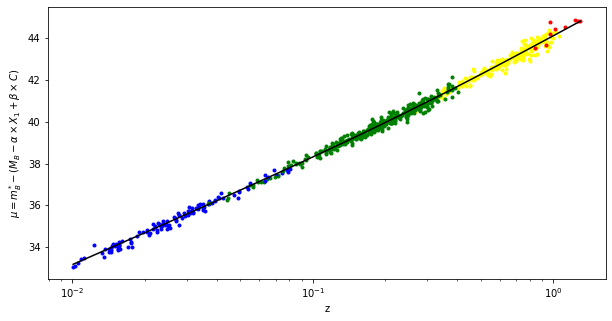

In [98]:
plt.figure(figsize=(10,5))
for i in range(740):
    if conjunto[i] == 3:
        plt.plot(z[i], mb[i] - (res[3] + res[4]*par_masa[i] - res[1]*x1[i] + res[2]*c[i]), '.', color = 'blue')
    elif conjunto[i] == 1:
        plt.plot(z[i], mb[i] - (res[3] + res[4]*par_masa[i] - res[1]*x1[i] + res[2]*c[i]), '.', color = 'yellow')
    elif conjunto[i] == 2:
        plt.plot(z[i], mb[i] - (res[3] + res[4]*par_masa[i] - res[1]*x1[i] + res[2]*c[i]), '.', color = 'green')
    else:
        plt.plot(z[i], mb[i] - (res[3] + res[4]*par_masa[i] - res[1]*x1[i] + res[2]*c[i]), '.', color = 'red')
plt.plot(datos_ord['z'], datos_ord['mu_stand'], '-', color = 'black');
plt.xscale('log')
plt.xlabel('z')
plt.ylabel(r'$\mu = m_{B}^{*} - (M_{B} - \alpha \times X_{1} + \beta \times C)$')